In [1]:
from math import pi as PI
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PINN.diff import diff
from PINN.networks import FCNN
from PINN.generators import generator_2dspatial_rectangle, generator_2dspatial_segment
from PINN.conditions import BoundaryCondition
from PINN.solvers import SingleNetworkApproximator2DSpatial
from PINN.monitors import Monitor2DSpatial
from PINN.solvers import _solve_2dspatial

In [8]:
r1=0.135 #内径
r2=0.1695  #外径
h1=0.02  #高

h=20602.3271
T0=303.15
k=1000 #传热系数

In [9]:
def heat_transfer(u , xx, yy):
    return diff(u, xx, order=2) + diff(u, yy, order=2)

def heat_transfer_norm(u,xx,yy):
    return k(diff(u,yy,order=2)+diff(u,xx,order=2)/(r2-r1)/(r2-r1)*h1*h1+diff(u,xx)/(xx*(r2-r1)*(r2-r1)+r1*(r2-r1))*h1*h1)
    #return diff(u,yy,order=2)/h1/h1+diff(u,xx,order=2)/(r2-r1)/(r2-r1)+diff(u,xx)/(xx*(r2-r1)*(r2-r1)+r1*(r2-r1))
# def analytical_solution(xx, yy):
#     return -1/(2*PI**2) * torch.sin(PI*xx) * torch.sin(PI*yy)
metrics = {}
# def rmse(uu, xx, yy):
#     error = uu - analytical_solution(xx, yy)
#     return torch.mean(error ** 2) ** 0.5
# metrics['rmse'] = rmse

#left
adiabatic_left=BoundaryCondition(
    form=lambda u, x, y: diff(u,x),
    
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 0.0), end=(0.0, 1.0)),
    weight=1
)
#bottom
adiabatic_bottom=BoundaryCondition(
    form=lambda u, x, y: diff(u,y),
    #form=lambda u, x, y: u,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 0.0), end=(1.0, 0.0)),
    weight=1
)
#right
convection_externel=BoundaryCondition(
    form=lambda u, x, y: u+k/(r2-r1)*diff(u,x)/h,
    #form=lambda u, x, y: u*h+k/(r2-r1)*diff(u,x),
    #form=lambda u, x, y: u+k*diff(u,x)/h,
    points_generator=generator_2dspatial_segment(size=32, start=(1.0, 0.0), end=(1.0, 1.0)),
    #weight=1/h/h/3
    weight=1
)
constant_interface=BoundaryCondition(
    #form=lambda u, x, y: u-torch.sin((1-x)*PI/2)-1,
    form=lambda u, x, y: u-torch.sin((1-x)*PI/2)-1,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 1.0), end=(1.0, 1.0)),
    weight=1
)

fcnn = FCNN(
    n_input_units=2,
    n_output_units=1,
    hidden_units=(64,64),
    actv=nn.Softplus
    #actv=nn.ReLU
)
fcnn_approximator = SingleNetworkApproximator2DSpatial(
    single_network=fcnn,
    pde=heat_transfer,
    boundary_conditions=[
        adiabatic_left,
        adiabatic_bottom,
        convection_externel,
        constant_interface
    ],
    boundary_strictness=1.0
)
adam = optim.Adam(fcnn_approximator.parameters(), lr=0.0006)

train_gen_spatial = generator_2dspatial_rectangle(size=(32, 32), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0)
valid_gen_spatial = generator_2dspatial_rectangle(size=(20, 20), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=False)

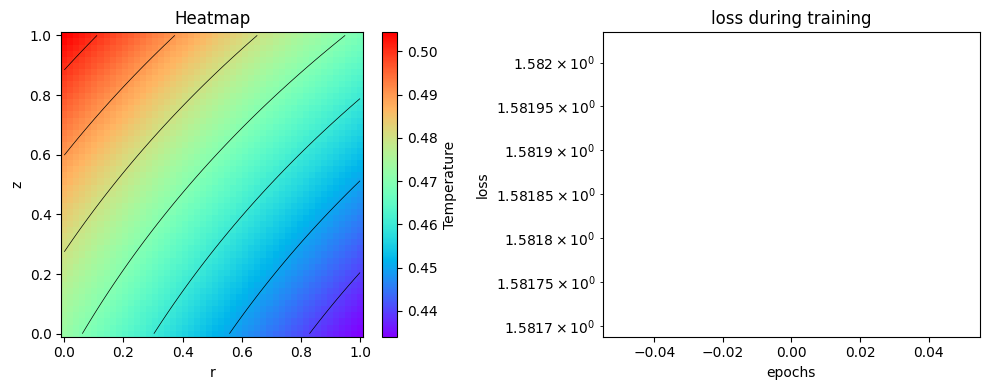

Already calculate for 0/20000
Already calculate for 1000/20000


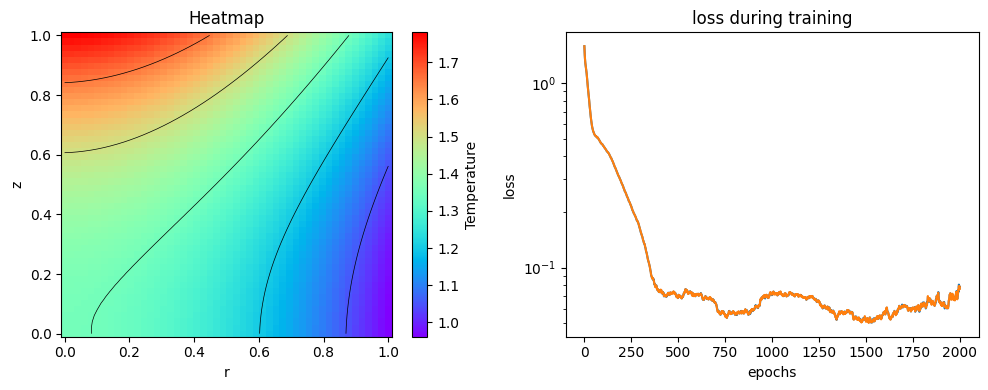

Already calculate for 2000/20000
Already calculate for 3000/20000


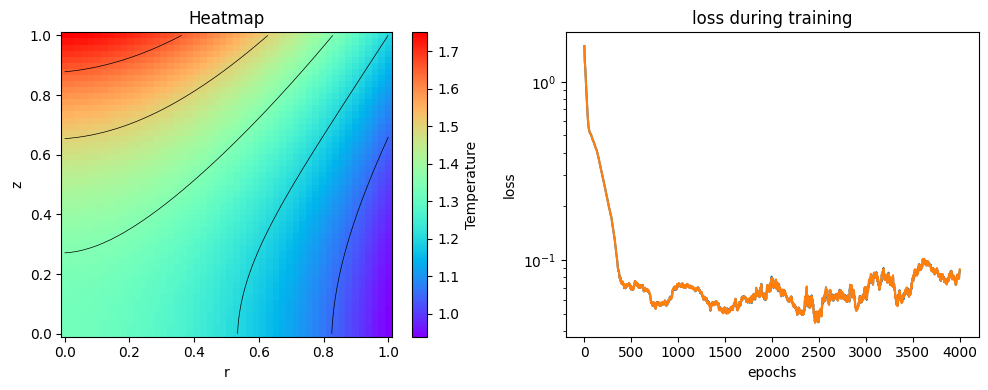

Already calculate for 4000/20000
Already calculate for 5000/20000


KeyboardInterrupt: 

In [10]:
%matplotlib inline
heat_transfer_2d_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=1024,
    max_epochs=20000,
    shuffle=True,
    metrics=metrics,
    monitor=Monitor2DSpatial(        
        check_on_x=torch.linspace(0.0, 1.0, 50),
        check_on_y=torch.linspace(0.0, 1.0, 50),
        check_every=2000
    )
)